<a href="https://colab.research.google.com/github/AndresMontesDeOca/Laboratorio3/blob/main/TimeSeriesSplit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import gzip
import shutil
import itertools
import json
import requests
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from urllib.request import urlretrieve

<Axes: xlabel='Date'>

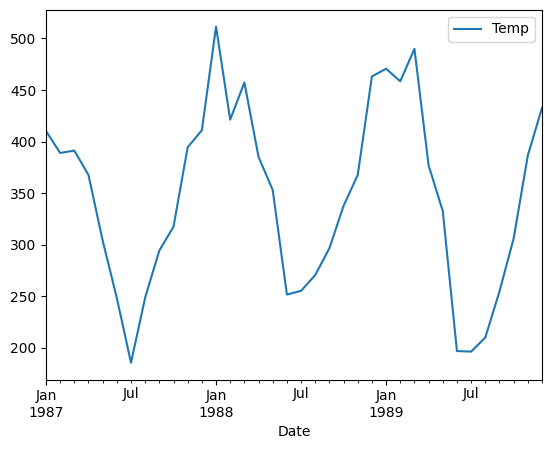

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar la serie temporal de temperaturas diarias de Nueva York
data_raw = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv')

# Convertir la columna 'Date' a tipo datetime y establecerla como índice
data_raw['Date'] = pd.to_datetime(data_raw['Date'])
data_raw.set_index('Date', inplace=True)

# Agrupar por mes y calcular la sumatoria de la temperatura
data = data_raw.resample('M').sum()

# Ajustar el índice para que sea el primer día del mes
data.index = data.index.to_period('M').to_timestamp()

data = data.loc['1987':'1989']

data.plot()